In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import scipy.stats

In [2]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
def load_subject(subject, data_directory):
    file_suffix = 'cells'
    df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

In [4]:
def reformat_significant_areas(df_ttest, alpha=0.05):
    """
    Identify significant areas based on statistical testing across experimental groups.

    Parameters:
    dictionary (dict): Dictionary containing data for multiple mice.
    experimental_groups (dict): Dictionary defining the experimental groups.
    value (str): The key in the dictionary whose values will be compared across groups.
    test (str): The statistical test to use (default is 'mannwhitneyu').
    alpha (float): The significance level for the test (default is 0.05).

    Returns:
    pd.DataFrame: A DataFrame containing significant areas with their p-values.
    """

    # Extract the column names corresponding to p-values
    columns = df_ttest.loc[:, df_ttest.columns != 'area'].columns

    # Initialize an empty DataFrame to store significant areas
    df_sigareas = pd.DataFrame()

    # Iterate through each p-value column to identify significant areas
    for col in columns:
        # Sort the DataFrame by the p-value column and select the areas with significant p-values
        df = df_ttest.sort_values(by=col)[['area', col]]
        df_sigareas = pd.concat([df_sigareas, df[df[col] < alpha]['area'].reset_index(drop=True)], axis=1)
    
    # Rename the columns to remove 'pval_' prefix
    df_sigareas.columns = [col.replace('pval_', '') for col in columns]

    return df_sigareas

In [5]:
def find_significant_areas(dictionary, experimental_groups, value, test='mannwhitneyu', alpha=0.05):
    """
    Identify significant areas based on statistical testing across experimental groups.

    This function performs a non-parametric statistical test (e.g., Mann-Whitney U) 
    across experimental groups to identify areas that show significant differences
    for a specified value (e.g., 'n_cells'). It returns a DataFrame containing the 
    areas with significant p-values.

    Parameters:
    dictionary (dict): Dictionary containing data for multiple mice.
    experimental_groups (dict): Dictionary defining the experimental groups.
    value (str): The key in the dictionary whose values will be compared across groups.
    test (str): The statistical test to use (default is 'mannwhitneyu').
    alpha (float): The significance level for the test (default is 0.05).

    Returns:
    pd.DataFrame: A DataFrame containing significant areas with their p-values.
    """
    
    # Calculate the specified value across experimental groups
    dfs = ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                            dict_results_across_mice=dictionary, 
                                            value=value)
    
    # Perform statistical tests across the groups
    df_ttest = ace.test_across_groups(dfs, test=test, groups=list(experimental_groups.keys()))

    # Extract the column names corresponding to p-values
    columns = df_ttest.loc[:, df_ttest.columns != 'area'].columns

    # Initialize an empty DataFrame to store significant areas
    df_sigareas = pd.DataFrame()

    # Iterate through each p-value column to identify significant areas
    for col in columns:
        # Sort the DataFrame by the p-value column and select the areas with significant p-values
        df = df_ttest.sort_values(by=col)[['area', col]]
        df_sigareas = pd.concat([df_sigareas, df[df[col] < alpha]['area'].reset_index(drop=True)], axis=1)
    
    # Rename the columns to remove 'pval_' prefix
    df_sigareas.columns = [col.replace('pval_', '') for col in columns]

    return df_sigareas

In [6]:
def plot_three_matrices(matrices):
    """
    Plot three correlation matrices side by side as heatmaps.

    This function creates a figure with three subplots, each displaying a heatmap of a correlation matrix.
    The heatmaps use a diverging color palette and the color bar is shown only for the last subplot.
    The x and y tick labels are displayed at regular intervals.

    Parameters:
    matrices (list): A list of three correlation matrices (pandas DataFrames).

    Returns:
    tuple: The figure and axes objects for further customization if needed.
    """

    # Create a figure with three subplots side by side
    f, ax = plt.subplots(1, 3, figsize=(12, 2.7))
    plt.subplots_adjust(top=0.97, bottom=0.2)

    # Loop over each matrix to plot
    for i, matrix in enumerate(matrices):
        # Display the color bar only for the last subplot
        cbar = False if i != 2 else True
        
        # Create the heatmap
        sns.heatmap(matrix,
                    cmap=sns.diverging_palette(220, 10, as_cmap=True),
                    vmin=-1.0, vmax=1.0,
                    square=True, cbar=cbar, ax=ax[i])
        
        # Remove axis labels
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')

        # Indices of the labels to show (every 12th)
        n = 12
        tick_indices = list(range(0, len(matrix.columns), n))
        tick_labels = matrix.columns[::n]

        # Set x and y ticks
        ax[i].set_xticks(tick_indices)
        ax[i].set_xticklabels(tick_labels)
        ax[i].set_yticks(tick_indices)
        ax[i].set_yticklabels(tick_labels)

    return f, ax

# Loading data

In [7]:
# dict_results_across_mice1 = np.load(
#     'dict_results/newvolumes/dict_results_across_mice_PISA_with_Pons_reformatted.npy', 
#                                    allow_pickle=True).item()
dict_results_across_mice = np.load(
    'dict_results/newvolumes/dict_results_across_mice_PISA_without_Pons.npy', 
                                   allow_pickle=True).item()

In [8]:
# reformat dictionary and subjects
def reformat_dict(dict_results_across_mice):
    old_keys = list(dict_results_across_mice.keys())
    for key in old_keys:
        group = key.split('_')[-1] if key.split('_')[-1][-1]!='2' else key.split('_')[-1][:-1]
        number = key.split('_')[0]
        new_key = 'BL'+number+group
        dict_results_across_mice[new_key] = dict_results_across_mice[key]
        del dict_results_across_mice[key]
    return dict_results_across_mice

In [9]:
dict_results_across_mice = reformat_dict(dict_results_across_mice=dict_results_across_mice)

In [10]:
del dict_results_across_mice['BL12noshock']

In [11]:
subjects = list(dict_results_across_mice.keys())
subjects

['BL13noshock',
 'BL4demonstrator',
 'BL9demonstrator',
 'BL2observer',
 'BL17demonstrator',
 'BL22demonstrator',
 'BL1noshock',
 'BL20noshock',
 'BL19noshock',
 'BL16observer',
 'BL15noshock',
 'BL10observer',
 'BL11noshock',
 'BL6demonstrator',
 'BL7noshock',
 'BL14demonstrator',
 'BL3demonstrator',
 'BL5observer',
 'BL18observer',
 'BL8observer',
 'BL21observer']

In [12]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=list(dict_results_across_mice.keys()),
                                                group_labels=['noshock','demonstrator', 'observer'])

# senza ponte

In [13]:
df_noshock_density, df_demonstrator_density, df_observer_density = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='density')
df_ttest_density = ace.test_across_groups([df_noshock_density,
                                          df_demonstrator_density,
                                          df_observer_density],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'],
                                        test='mannwhitneyu')

In [14]:
df_ttest_density.to_csv('pvalue_density_PISA26092024.csv')

In [15]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='density',
                       test='mannwhitneyu',
                      alpha=0.05)[0:10]

,noshock_vs_demonstrator,noshock_vs_observer,demonstrator_vs_observer
0,Suprachiasmatic preoptic nucleus,Posterolateral visual area,Nucleus circularis
1,Substantia nigra lateral part,Dorsomedial nucleus of the hypothalamus,Anterior hypothalamic area
2,Lateral strip of striatum,Substantia nigra lateral part,Substantia nigra lateral part
3,Retroethmoid nucleus,Intercollicular nucleus,Lateral strip of striatum
4,Intercollicular nucleus,Suprachiasmatic preoptic nucleus,Suprachiasmatic preoptic nucleus
5,Anterior hypothalamic area,Anterior hypothalamic area,Retroethmoid nucleus
6,Nucleus circularis,Lateral strip of striatum,Intercollicular nucleus
7,Pineal body,Retroethmoid nucleus,Pineal body
8,Taenia tecta,Nucleus circularis,Preparasubthalamic nucleus
9,Cortical amygdalar area,Pineal body,NaN


# Loading area list

In [16]:
areas = pd.read_csv('T2_struct_nomenclature.csv')

# Correlations across number of cells

In [17]:
# create correlation matrices

#make deep copy of dataframes not to change the original object
dfs = [df_noshock_density.copy(deep=True), 
       df_demonstrator_density.copy(deep=True), 
       df_observer_density.copy(deep=True)]

# Rename brain areas with acronyms
for df in dfs:
    for i in df.index:
        df.at[i, 'area'] = volumes[volumes['safe_name'] == df.at[i, 'area']]['acronym'].values[0]

# Remove rows with null values or where all values are zero
for i, df in enumerate(dfs):
    df = df.set_index('area')
    df = df.loc[~(df == 0).all(axis=1)].dropna(axis=0)
    dfs[i] = df

# Find intersecting indexes (areas) across all DataFrames
indexes_intersect = dfs[0].index.intersection(dfs[1].index).intersection(dfs[2].index).intersection(set(areas['acronym']))

# Initialize a list to store correlation matrices
matrices_PISA_density = []

# Create correlation matrices for each DataFrame
for df in dfs:
    df = df.loc[indexes_intersect]
    corr_matrix = df.T.corr(method='pearson')
    matrices_PISA_density.append(corr_matrix)

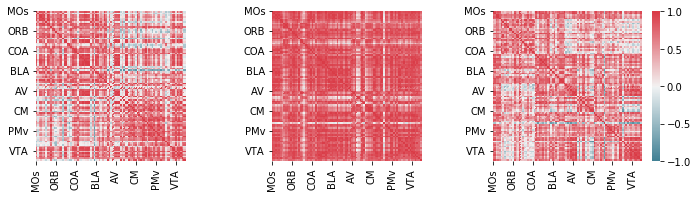

In [18]:
plot_three_matrices(matrices=matrices_PISA_density)
plt.savefig('fig5_panel_correlation_matrices.svg')
plt.savefig('fig5_panel_correlation_matrices.png', dpi=300)

In [19]:
def plot_upper_triangle_distributions(corr_matrices):
    corr_matrix1, corr_matrix2, corr_matrix3 = corr_matrices
    # Function to extract the upper triangular values excluding the diagonal
    def upper_triangle_values(matrix):
        upper_tri = matrix.where(np.triu(np.ones(matrix.shape), k=1).astype(bool))
        return upper_tri.stack().values  # Flatten and remove NaNs
    
    # Extract upper triangular values from each correlation matrix
    upper_vals1 = upper_triangle_values(corr_matrix1)
    upper_vals2 = upper_triangle_values(corr_matrix2)
    upper_vals3 = upper_triangle_values(corr_matrix3)
    
    # Set up the seaborn color palette (Accent2)
    palette = sns.color_palette("Accent", n_colors=3)
    
    # Create the plot
    plt.figure(figsize=(5, 5))
    
    # Plot distributions
    sns.kdeplot(upper_vals1, label='NO SHOCK', color=palette[0], shade=True)
    sns.kdeplot(upper_vals2, label='DEMONSTRATOR', color=palette[1], shade=True)
    sns.kdeplot(upper_vals3, label='OBSERVER', color=palette[2], shade=True)
    
    # Add titles and labels
    plt.xlabel('Correlation Values')
    plt.ylabel('Density')
    plt.legend(loc='upper left')
    

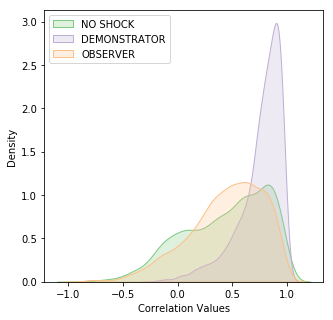

In [20]:
plot_upper_triangle_distributions(corr_matrices=matrices_PISA_density)
plt.savefig('fig5_panel_correlation_distributions.svg')
plt.savefig('fig5_panel_correlation_distributions.png', dpi=300)

# Histograms of counts of all measures across significant areas

## density

In [21]:
def stack(areas, dfs, volumes):
    areas_safe_name = [volumes[volumes['acronym']==area]['safe_name'].values[0] for area in areas]

    df1 = pd.DataFrame(columns=['area', 'density', 'group'])
    df2 = pd.DataFrame(columns=['area', 'density', 'group'])
    df3 = pd.DataFrame(columns=['area', 'density', 'group'])
    
    df1['area'] = areas
    df1['group'] = ['NO SHOCK' for area in areas_safe_name]
    df1['density'] = [dfs[0].set_index('area').loc[area].mean() for area in areas_safe_name]

    df2['area'] = areas
    df2['group'] = ['DEMONSTRATOR' for area in areas_safe_name]
    df2['density'] = [dfs[1].set_index('area').loc[area].mean() for area in areas_safe_name]

    df3['area'] = areas
    df3['group'] = ['OBSERVER' for area in areas_safe_name]
    df3['density'] = [dfs[2].set_index('area').loc[area].mean() for area in areas_safe_name]
    
    return df1.append(df2).append(df3)

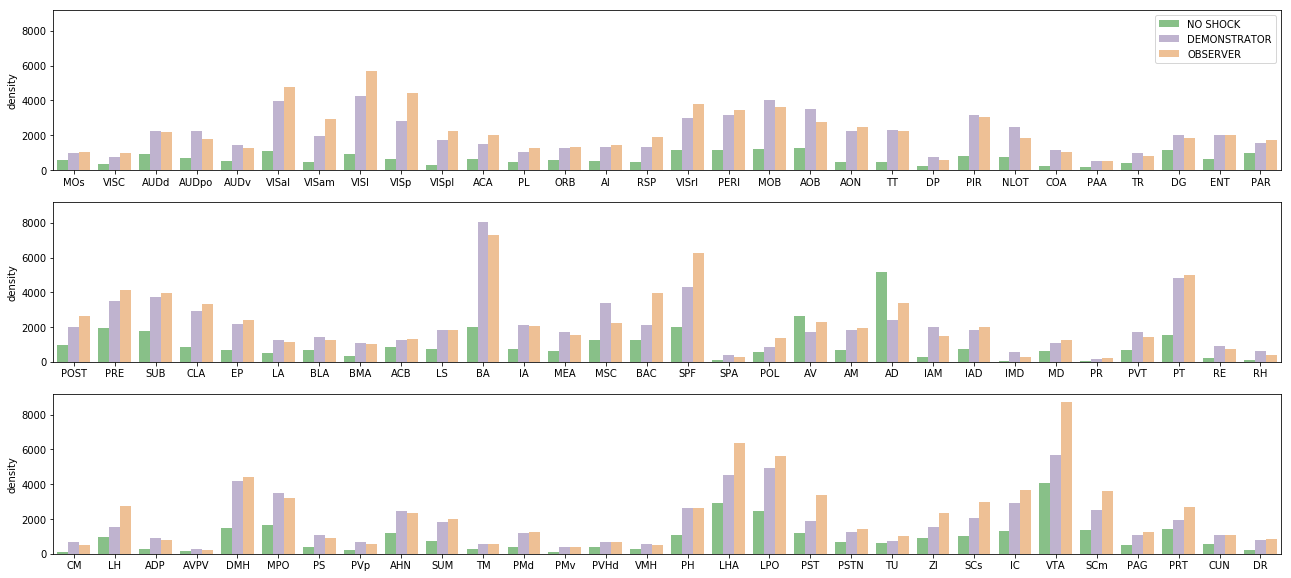

In [22]:
# stack1
areas_ordered = [area for area in volumes['acronym'].values if area in areas['acronym'].to_list()]


stack1 = stack(areas_ordered[:30], dfs=[df_noshock_density,
                                df_demonstrator_density,
                                df_observer_density],
              volumes=volumes)
stack2 = stack(areas_ordered[30:60], dfs=[df_noshock_density,
                                df_demonstrator_density,
                                df_observer_density],
              volumes=volumes)
stack3 = stack(areas_ordered[60:], dfs=[df_noshock_density,
                                df_demonstrator_density,
                                df_observer_density],
              volumes=volumes)


f, ax = plt.subplots(ncols=1, nrows=3, gridspec_kw={'hspace':0.2}, figsize=(22,10), sharey=True)
sns.barplot(
    data=stack1,
    x="area", y="density", hue="group", palette="Accent", ax=ax[0])
ax[0].set_xlabel('')
sns.barplot(
    data=stack2,
    x="area", y="density", hue="group", palette="Accent", ax=ax[1])
ax[1].legend_.remove()
ax[1].set_xlabel('')
sns.barplot(
    data=stack3,
    x="area", y="density", hue="group", palette="Accent", ax=ax[2])
ax[2].legend_.remove()
ax[2].set_xlabel('')
ax[0].legend().set_title('')
plt.savefig('fig5_histograms.svg')
plt.savefig('fig5_histograms.png', dpi=300)

# VOLCANO PLOTS

In [23]:
def calculate_fold_change(df, df_control):
    
    # Compute the mean across subjects for both control and condition groups, excluding the 'area' column
    control_means = df_control.drop(columns=['area']).mean(axis=1)
    df_means = df.drop(columns=['area']).mean(axis=1)
    
    # Calculate fold change (condition / control) for each area
    fold_change = df_means / control_means
    
    # Create a DataFrame to store the results along with the area names
    fold_change_df = pd.DataFrame({
        'area': df['area'],
        'fold_change': fold_change
    })
    
    return fold_change_df

In [24]:
fold_change_demonstrator = calculate_fold_change(df=df_demonstrator_density, df_control=df_noshock_density)
fold_change_observer = calculate_fold_change(df=df_observer_density, df_control=df_noshock_density)

In [37]:
def plot_volcano(fold_change_df, pvalue_df, comparison_name, ax, highlight_areas=None, dot_size=100):
    # Ensure p-values are numeric and handle any invalid values
    pvalue_df = pd.to_numeric(pvalue_df, errors='coerce')  # Convert to numeric, replace invalid with NaN
    pvalue_df = pvalue_df.fillna(1)  # Replace NaN values with 1 (so log10(p) = 0)
    
    # Calculate log2 fold change and -log10 p-values
    log2_fold_change = np.log2(fold_change_df['fold_change'])
    neg_log10_pvalue = -np.log10(pvalue_df)

    # Create a DataFrame for plotting
    plot_data = pd.DataFrame({
        'log2_fold_change': log2_fold_change,
        '-log10_pvalue': neg_log10_pvalue,
        'area': fold_change_df['area']
    })

    # Add a column to differentiate significant points (p-value < 0.05)
    plot_data['significant'] = pvalue_df < 0.05
    
    # Add a column to highlight specific areas (based on significant areas from another plot)
    if highlight_areas is not None:
        plot_data['highlight'] = plot_data['area'].isin(highlight_areas)
    else:
        plot_data['highlight'] = False
    
    # Color logic: Green for highlighted, blue for significant, black for non-significant (p > 0.05)
    plot_data['color'] = np.where(plot_data['significant'],
                                  np.where(plot_data['highlight'], 'green', 'blue'),
                                  'black')

    # Create volcano plot using Seaborn
    sns.scatterplot(
        data=plot_data, x='log2_fold_change', y='-log10_pvalue', 
        hue='color', palette={'green': 'green', 'blue': 'blue', 'black': 'black'}, 
        ax=ax, legend=True, s=dot_size
    )
    
    # Customize the plot
    ax.set_title(f'Volcano Plot: {comparison_name}', fontsize=18)
    ax.set_xlabel('Log2(Fold Change)', fontsize=14)
    ax.set_ylabel('-Log10(p-value)', fontsize=14)
    
    # Add threshold lines
    ax.axhline(y=-np.log10(0.05), color='red', linestyle='--')
    ax.axvline(x=0, color='black', linestyle='--')  # Threshold between up/down regulation

    # Set the tick label size
    ax.tick_params(labelsize=12)

def plot_multiple_volcano(fold_change_observer, fold_change_demonstrator, pvals_df, dot_size=100):
    # Set up a 1x2 subplot for observer and demonstrator
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
    
    # Identify significant areas in the demonstrator plot (p-value < 0.05)
    significant_demonstrator_areas = fold_change_demonstrator['area'][pvals_df['pval_noshock_vs_demonstrator'] < 0.05]

    # Plot observer volcano, highlighting significant demonstrator areas
    plot_volcano(fold_change_observer, pvals_df['pval_noshock_vs_observer'], 'Observer', axes[0], 
                 highlight_areas=significant_demonstrator_areas, dot_size=dot_size)
    
    # Plot demonstrator volcano
    plot_volcano(fold_change_demonstrator, pvals_df['pval_noshock_vs_demonstrator'], 'Demonstrator', axes[1], 
                 dot_size=dot_size)

    # Add a legend to the observer panel to indicate green dots are significant in both conditions
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles, ['Significant in Observer', 'Not significant', 'Significant in Both'], loc='upper left', fontsize=12)
    axes[1].get_legend().remove()
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()


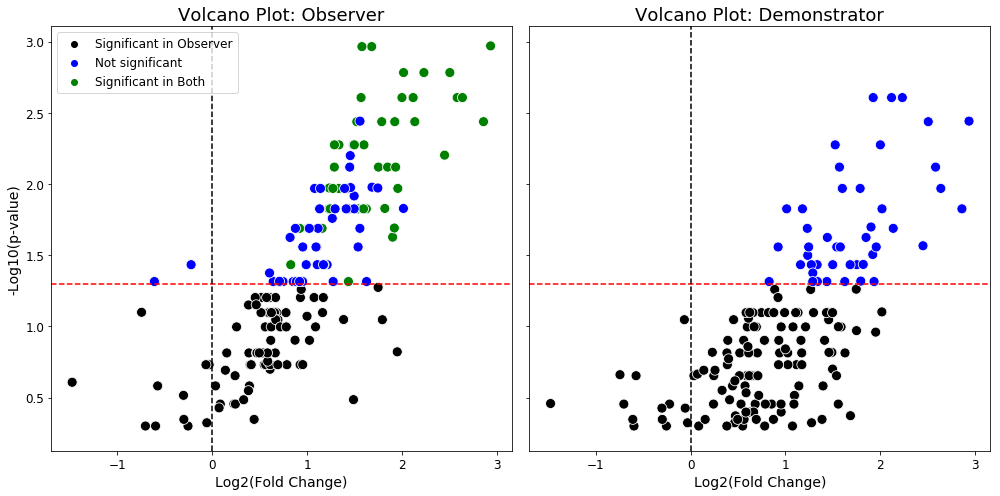

<Figure size 432x288 with 0 Axes>

In [39]:
plot_multiple_volcano(fold_change_observer=fold_change_observer, 
                      fold_change_demonstrator=fold_change_observer, 
                      pvals_df=df_ttest_density)
plt.savefig('fig5_volcano_plot.svg')
plt.savefig('fig5_volcano_plot.png', dpi=300)